# **Spaceship Titanic**

## Description:

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# 1. Importing Libraries

In [1]:
library(stats)
library(readr)
library(tidyverse)
library(funModeling)
library(dplyr)
library(missForest)
library(mice)
library(ggpubr)
library(corrplot)
library(rsample)
library(recipes)
library(parsnip)
library(dials)
library(tidymodels)
library(car)
library(vip)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ dplyr   1.0.10
✔ tibble  3.1.8      ✔ stringr 1.5.0 
✔ tidyr   1.2.1      ✔ forcats 0.5.2 
✔ purrr   1.0.1      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


funModeling v.1.9.4 :)
Examples and tutorials at livebook.datascienceheroes.com
 / Now in Spanish: librovivodecienciadedatos.ai


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind




# 2. Loading Datasets

In [2]:
# Train data
train <- read_csv("/kaggle/input/spaceship-titanic/train.csv",show_col_types = FALSE)
head(train)

PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
<chr>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
0001_01,Europa,FALSE,B/0/P,TRAPPIST-1e,39,FALSE,0,0,0,0,0,Maham Ofracculy,FALSE
0002_01,Earth,FALSE,F/0/S,TRAPPIST-1e,24,FALSE,109,9,25,549,44,Juanna Vines,TRUE
0003_01,Europa,FALSE,A/0/S,TRAPPIST-1e,58,TRUE,43,3576,0,6715,49,Altark Susent,FALSE
0003_02,Europa,FALSE,A/0/S,TRAPPIST-1e,33,FALSE,0,1283,371,3329,193,Solam Susent,FALSE
0004_01,Earth,FALSE,F/1/S,TRAPPIST-1e,16,FALSE,303,70,151,565,2,Willy Santantines,TRUE
0005_01,Earth,FALSE,F/0/P,PSO J318.5-22,44,FALSE,0,483,0,291,0,Sandie Hinetthews,TRUE


# 3. Pre-processing of data

In [3]:
# Separating PassengerId into 2 parts
train <-train %>%
    separate(PassengerId, c("Group", "Num"), sep = "_", remove = FALSE) 
# Separating Cabin into 3 parts
train <- train %>%
    separate(Cabin, c("CabinDeck", "CabinNum", "CabinSide"), sep = "/") 
head(train)

PassengerId,Group,Num,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSide,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
0001_01,0001,01,Europa,FALSE,B,0,P,TRAPPIST-1e,39,FALSE,0,0,0,0,0,Maham Ofracculy,FALSE
0002_01,0002,01,Earth,FALSE,F,0,S,TRAPPIST-1e,24,FALSE,109,9,25,549,44,Juanna Vines,TRUE
0003_01,0003,01,Europa,FALSE,A,0,S,TRAPPIST-1e,58,TRUE,43,3576,0,6715,49,Altark Susent,FALSE
0003_02,0003,02,Europa,FALSE,A,0,S,TRAPPIST-1e,33,FALSE,0,1283,371,3329,193,Solam Susent,FALSE
0004_01,0004,01,Earth,FALSE,F,1,S,TRAPPIST-1e,16,FALSE,303,70,151,565,2,Willy Santantines,TRUE
0005_01,0005,01,Earth,FALSE,F,0,P,PSO J318.5-22,44,FALSE,0,483,0,291,0,Sandie Hinetthews,TRUE


In [4]:
# Size by groups
train <-train %>% add_count(Group, name = "GroupSize")

In [5]:
# Grouping ages
train <- train %>%
         mutate(Age_group = case_when(Age <= 10  ~ "kid",
                                      Age > 10 & Age <= 18  ~ "teen",
                                      Age > 18 & Age <= 60  ~ "adult",
                                      Age > 60 ~ "old_mw"))
head(train)

PassengerId,Group,Num,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSide,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupSize,Age_group
<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<int>,<chr>
0001_01,0001,01,Europa,FALSE,B,0,P,TRAPPIST-1e,39,FALSE,0,0,0,0,0,Maham Ofracculy,FALSE,1,adult
0002_01,0002,01,Earth,FALSE,F,0,S,TRAPPIST-1e,24,FALSE,109,9,25,549,44,Juanna Vines,TRUE,1,adult
0003_01,0003,01,Europa,FALSE,A,0,S,TRAPPIST-1e,58,TRUE,43,3576,0,6715,49,Altark Susent,FALSE,2,adult
0003_02,0003,02,Europa,FALSE,A,0,S,TRAPPIST-1e,33,FALSE,0,1283,371,3329,193,Solam Susent,FALSE,2,adult
0004_01,0004,01,Earth,FALSE,F,1,S,TRAPPIST-1e,16,FALSE,303,70,151,565,2,Willy Santantines,TRUE,1,teen
0005_01,0005,01,Earth,FALSE,F,0,P,PSO J318.5-22,44,FALSE,0,483,0,291,0,Sandie Hinetthews,TRUE,1,adult


In [6]:
# Removing columns that contribute nothing
train <-train %>% select(-c(Group, Num, CabinNum, Age, Name))
head(train)

PassengerId,HomePlanet,CryoSleep,CabinDeck,CabinSide,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,Age_group
<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<chr>
0001_01,Europa,FALSE,B,P,TRAPPIST-1e,FALSE,0,0,0,0,0,FALSE,1,adult
0002_01,Earth,FALSE,F,S,TRAPPIST-1e,FALSE,109,9,25,549,44,TRUE,1,adult
0003_01,Europa,FALSE,A,S,TRAPPIST-1e,TRUE,43,3576,0,6715,49,FALSE,2,adult
0003_02,Europa,FALSE,A,S,TRAPPIST-1e,FALSE,0,1283,371,3329,193,FALSE,2,adult
0004_01,Earth,FALSE,F,S,TRAPPIST-1e,FALSE,303,70,151,565,2,TRUE,1,teen
0005_01,Earth,FALSE,F,P,PSO J318.5-22,FALSE,0,483,0,291,0,TRUE,1,adult


### Variable types

In [7]:
glimpse(train)

Rows: 8,693
Columns: 15
$ PassengerId  <chr> "0001_01", "0002_01", "0003_01", "0003_02", "0004_01", "0…
$ HomePlanet   <chr> "Europa", "Earth", "Europa", "Europa", "Earth", "Earth", …
$ CryoSleep    <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, FA…
$ CabinDeck    <chr> "B", "F", "A", "A", "F", "F", "F", "G", "F", "B", "B", "B…
$ CabinSide    <chr> "P", "S", "S", "S", "S", "P", "S", "S", "S", "P", "P", "P…
$ Destination  <chr> "TRAPPIST-1e", "TRAPPIST-1e", "TRAPPIST-1e", "TRAPPIST-1e…
$ VIP          <lgl> FALSE, FALSE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FA…
$ RoomService  <dbl> 0, 109, 43, 0, 303, 0, 42, 0, 0, 0, 0, 39, 73, 719, 8, 32…
$ FoodCourt    <dbl> 0, 9, 3576, 1283, 70, 483, 1539, 0, 785, 0, 0, 7295, 0, 1…
$ ShoppingMall <dbl> 0, 25, 0, 371, 151, 0, 3, 0, 17, 0, NA, 589, 1123, 65, 12…
$ Spa          <dbl> 0, 549, 6715, 3329, 565, 291, 0, 0, 216, 0, 0, 110, 0, 0,…
$ VRDeck       <dbl> 0, 44, 49, 193, 2, 0, 0, NA, 0, 0, 0, 124, 113, 24, 7, 0,…
$ Transported  <

In [8]:
df_status(train)

       variable q_zeros p_zeros q_na p_na q_inf p_inf      type unique
1   PassengerId       0    0.00    0 0.00     0     0 character   8693
2    HomePlanet       0    0.00  201 2.31     0     0 character      3
3     CryoSleep    5439   62.57  217 2.50     0     0   logical      2
4     CabinDeck       0    0.00  199 2.29     0     0 character      8
5     CabinSide       0    0.00  199 2.29     0     0 character      2
6   Destination       0    0.00  182 2.09     0     0 character      3
7           VIP    8291   95.38  203 2.34     0     0   logical      2
8   RoomService    5577   64.16  181 2.08     0     0   numeric   1273
9     FoodCourt    5456   62.76  183 2.11     0     0   numeric   1507
10 ShoppingMall    5587   64.27  208 2.39     0     0   numeric   1115
11          Spa    5324   61.24  183 2.11     0     0   numeric   1327
12       VRDeck    5495   63.21  188 2.16     0     0   numeric   1306
13  Transported    4315   49.64    0 0.00     0     0   logical      2
14    

> No duplicate PassengerId (total=8693 , unique=8693)

### Visualizing NA Data

In [9]:
# NA data by attribute
apply(X = is.na(train), MARGIN = 2, FUN = sum)

PassengerId   HomePlanet    CryoSleep    CabinDeck    CabinSide  Destination 
           0          201          217          199          199          182 
         VIP  RoomService    FoodCourt ShoppingMall          Spa       VRDeck 
         203          181          183          208          183          188 
 Transported    GroupSize    Age_group 
           0            0          179

In [10]:
# NA data by rows
row_NA<-apply(X = is.na(train), MARGIN = 1, FUN = sum) 
# Maximum NA values per row
max(row_NA)

[1] 4

## Data imputation

* ### Analyzing columns to impute values

#### Home Planet

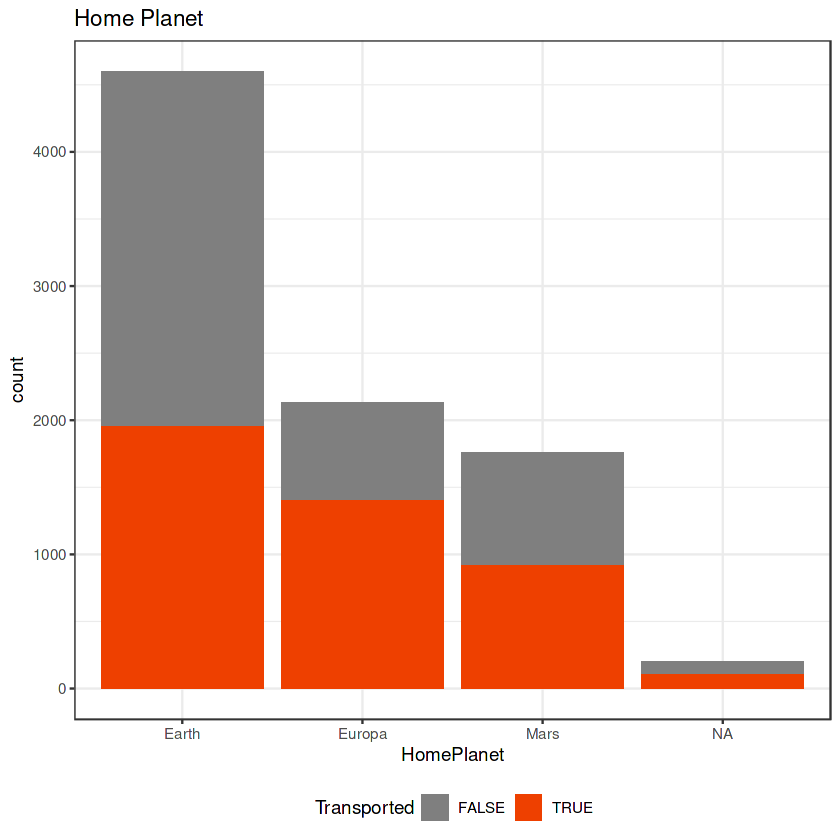

In [11]:
# Home Planet by category
ggplot(data = train, aes(x = HomePlanet, y = after_stat(count), fill = Transported)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Home Planet") +
  theme_bw() +
  theme(legend.position = "bottom")

> Change the NA for Earth, because it is the majority group

In [12]:
train$HomePlanet <- train$HomePlanet %>% replace(is.na(.),"Earth")

#### CryoSleep

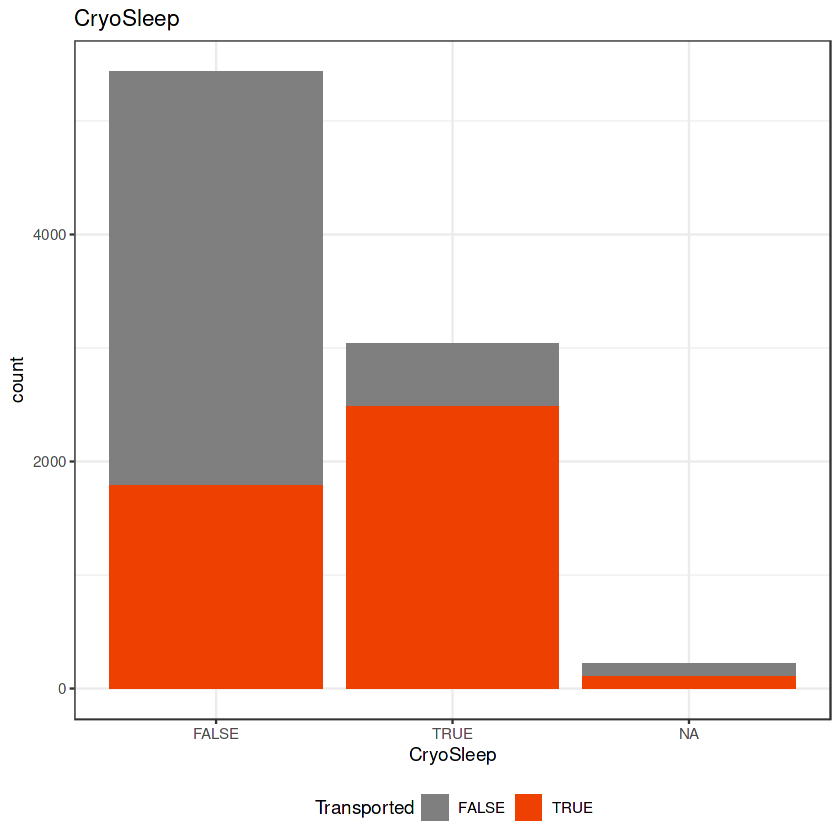

In [13]:
# CryoSleep by category
ggplot(data = train, aes(x = CryoSleep, y = after_stat(count), fill = Transported)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "CryoSleep") +
  theme_bw() +
  theme(legend.position = "bottom")

> Change the NA for FALSE, because it is the majority group

In [14]:
train$CryoSleep <- train$CryoSleep %>% replace(is.na(.),"FALSE")

#### CabinDeck

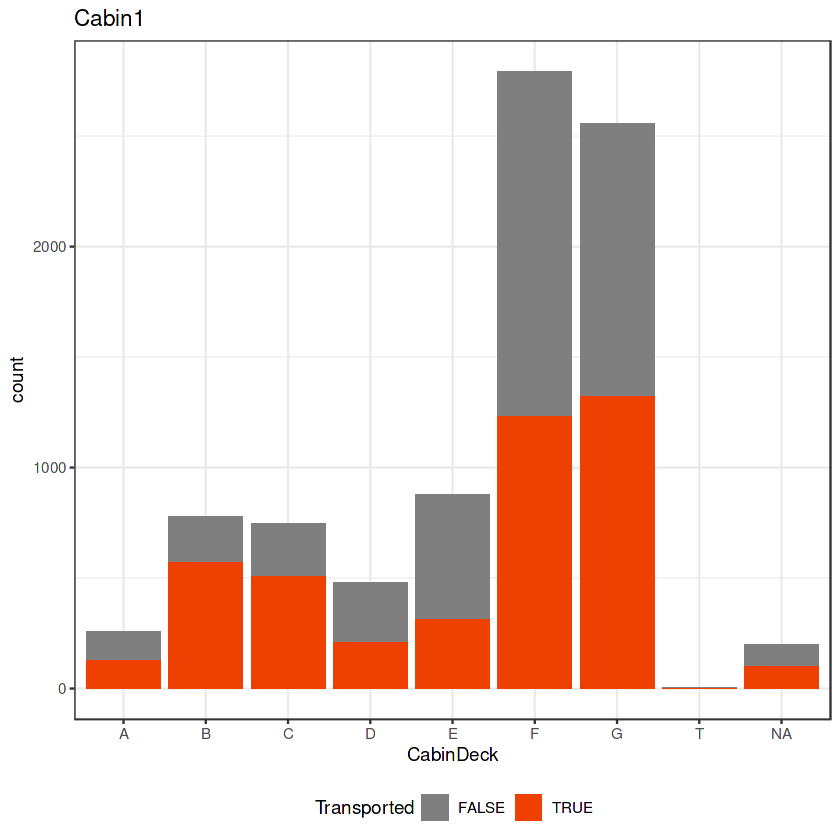

In [15]:
# CabinDeck by category
ggplot(data = train, aes(x = CabinDeck, y = after_stat(count), fill = Transported)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Cabin1") +
  theme_bw() +
  theme(legend.position = "bottom")

> Convert the NA values into an additional category "N", because the amount of NA is greater than those of cabin "T" and close to those of "A"

In [16]:
train$CabinDeck <- train$CabinDeck %>% replace(is.na(.),"N")

#### CabinSide

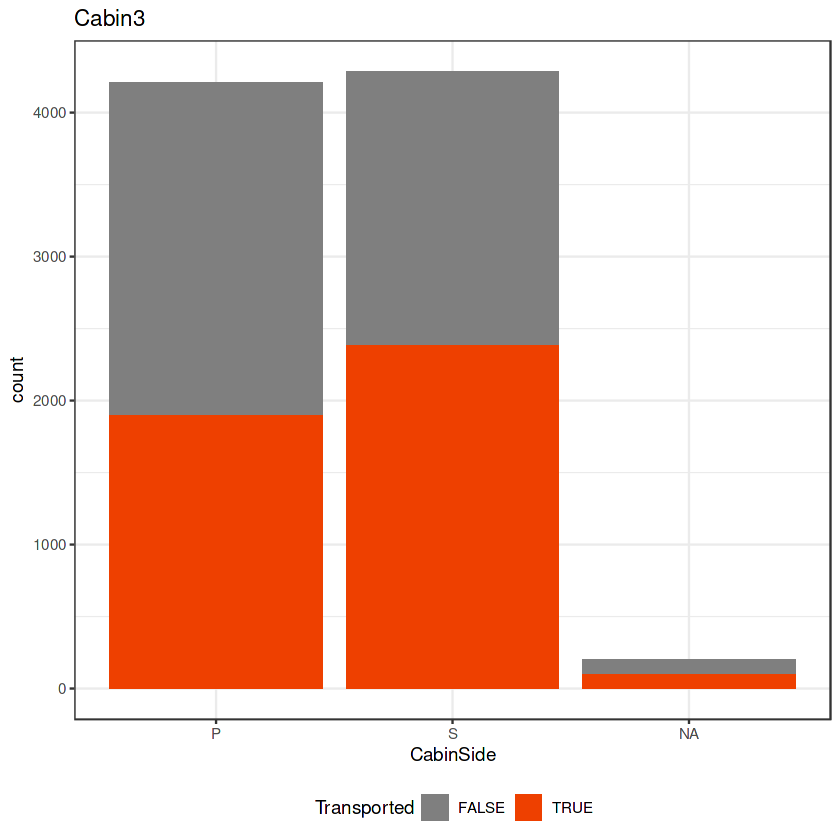

In [17]:
# CabinSide by category
ggplot(data = train, aes(x = CabinSide, y = after_stat(count), fill = Transported)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Cabin3") +
  theme_bw() +
  theme(legend.position = "bottom")

> Convert the NA values into an additional category "N", because there is a similar amount between "P" and "S"

In [18]:
train$CabinSide <- train$CabinSide %>% replace(is.na(.),"N")

#### Destination

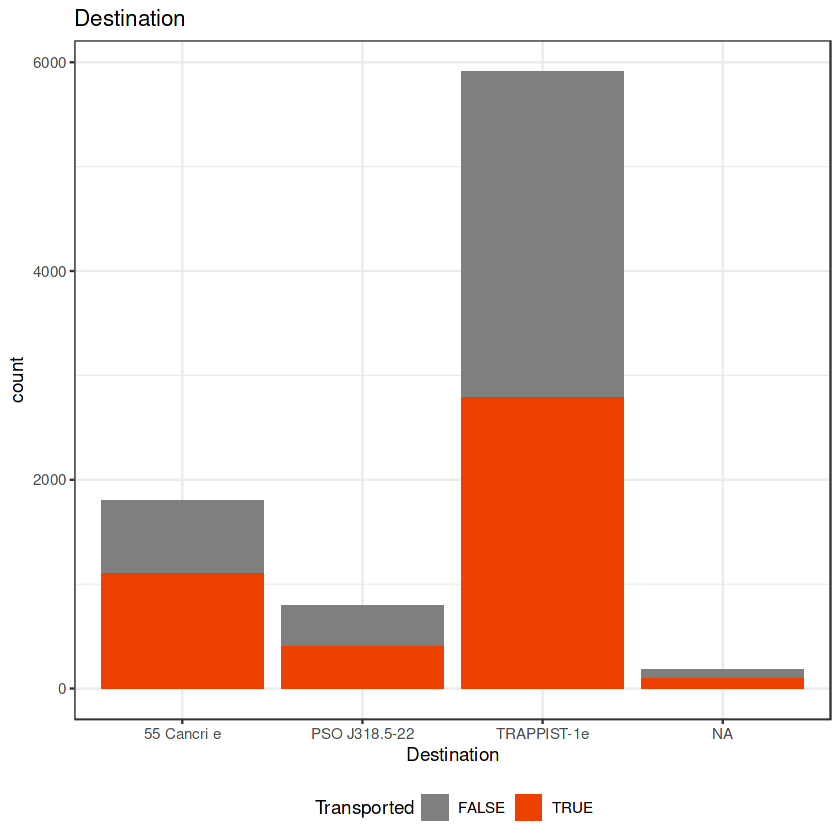

In [19]:
# Destination by category
ggplot(data = train, aes(x = Destination, y = after_stat(count), fill = Transported)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Destination") +
  theme_bw() +
  theme(legend.position = "bottom")

> Change the NA for TRAPPIST-1e, because it is the majority group

In [20]:
train$Destination <- train$Destination %>% replace(is.na(.),"TRAPPIST-1e")

#### VIP

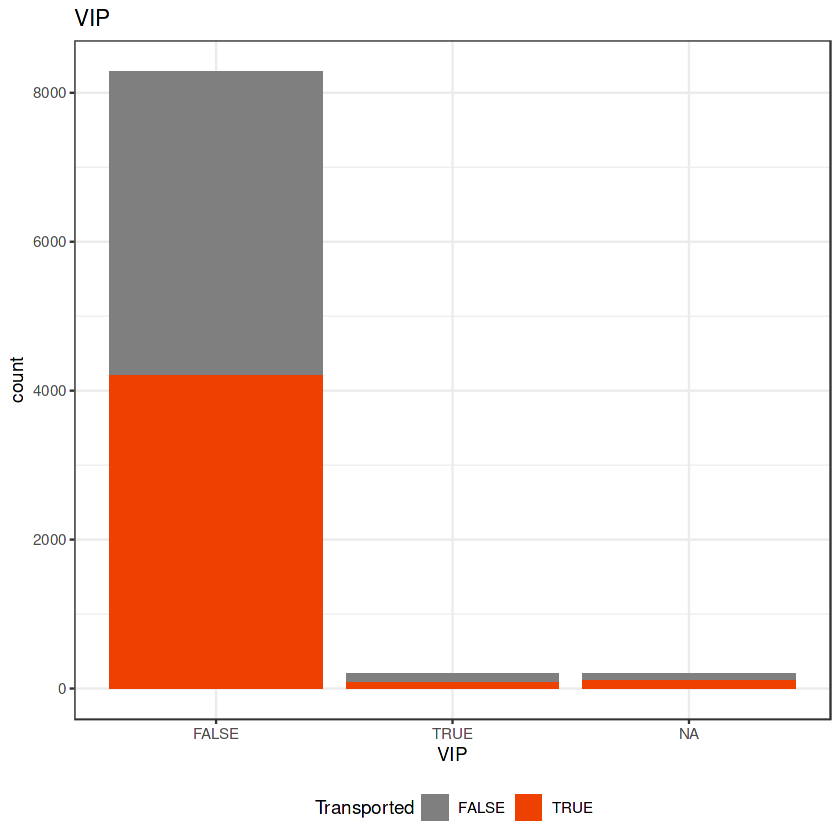

In [21]:
# VIP by category
ggplot(data = train, aes(x = VIP, y = after_stat(count), fill = Transported)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "VIP") +
  theme_bw() +
  theme(legend.position = "bottom")

> Convert NA values to "FALSE", because most are FALSE

In [22]:
train$VIP <- train$VIP %>% replace(is.na(.),"FALSE")

#### RoomService, FoodCourt, ShoppingMall, Spa and VRDeck

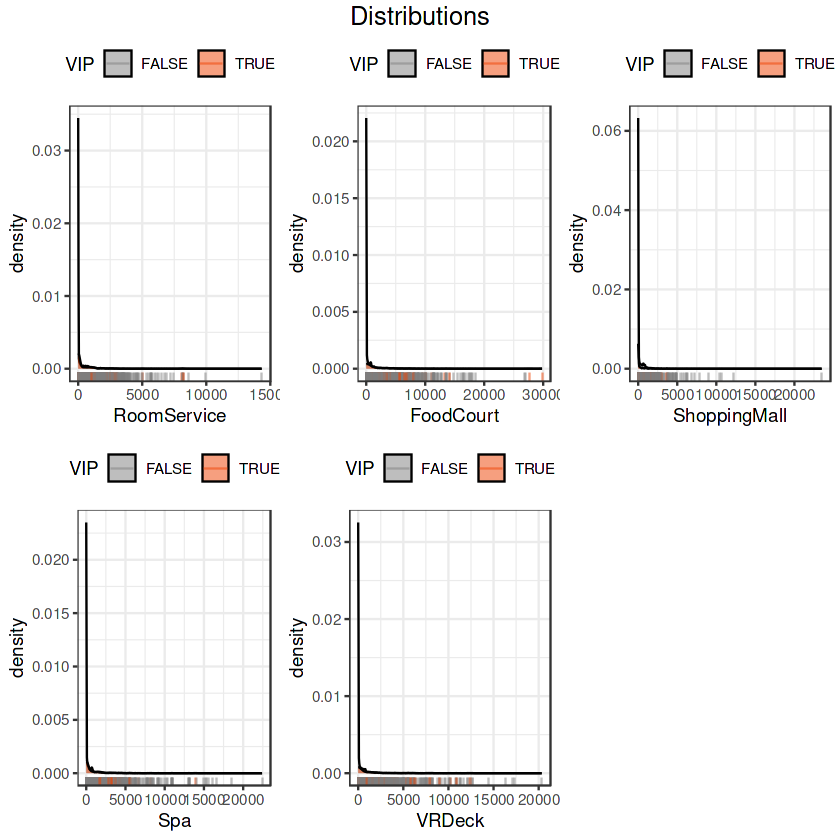

In [23]:
p1 <- ggplot(data = na.omit(train), aes(x = RoomService, fill = VIP)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2","red")) +
      geom_rug(aes(color = VIP), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2","red")) +
      theme_bw()
p2 <- ggplot(data = na.omit(train), aes(x = FoodCourt, fill = VIP)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2","red")) +
      geom_rug(aes(color = VIP), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2","red")) +
      theme_bw()
p3 <- ggplot(data = na.omit(train), aes(x = ShoppingMall, fill = VIP)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2","red")) +
      geom_rug(aes(color = VIP), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2","red")) +
      theme_bw()
p4 <- ggplot(data = na.omit(train), aes(x = Spa, fill = VIP)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2","red")) +
      geom_rug(aes(color = VIP), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2","red")) +
      theme_bw()
p5 <- ggplot(data = na.omit(train), aes(x = VRDeck, fill = VIP)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2","red")) +
      geom_rug(aes(color = VIP), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2","red")) +
      theme_bw()
final_plot <- ggarrange(p1, p2,p3,p4, p5, legend = "top")
final_plot <- annotate_figure(final_plot, top = text_grob("Distributions", size =15))
final_plot

> They aren't normal distributions, so the values of NA are considered as the median

In [24]:
summary(train%>% select(c(8:12)))

  RoomService        FoodCourt        ShoppingMall          Spa         
 Min.   :    0.0   Min.   :    0.0   Min.   :    0.0   Min.   :    0.0  
 1st Qu.:    0.0   1st Qu.:    0.0   1st Qu.:    0.0   1st Qu.:    0.0  
 Median :    0.0   Median :    0.0   Median :    0.0   Median :    0.0  
 Mean   :  224.7   Mean   :  458.1   Mean   :  173.7   Mean   :  311.1  
 3rd Qu.:   47.0   3rd Qu.:   76.0   3rd Qu.:   27.0   3rd Qu.:   59.0  
 Max.   :14327.0   Max.   :29813.0   Max.   :23492.0   Max.   :22408.0  
 NA's   :181       NA's   :183       NA's   :208       NA's   :183      
     VRDeck       
 Min.   :    0.0  
 1st Qu.:    0.0  
 Median :    0.0  
 Mean   :  304.9  
 3rd Qu.:   46.0  
 Max.   :24133.0  
 NA's   :188      

> Replace the NA values by 0, because it's the median of each one

In [25]:
train <- mutate_at(train, c(8:12), ~replace(., is.na(.), 0))

#### Age_grupo

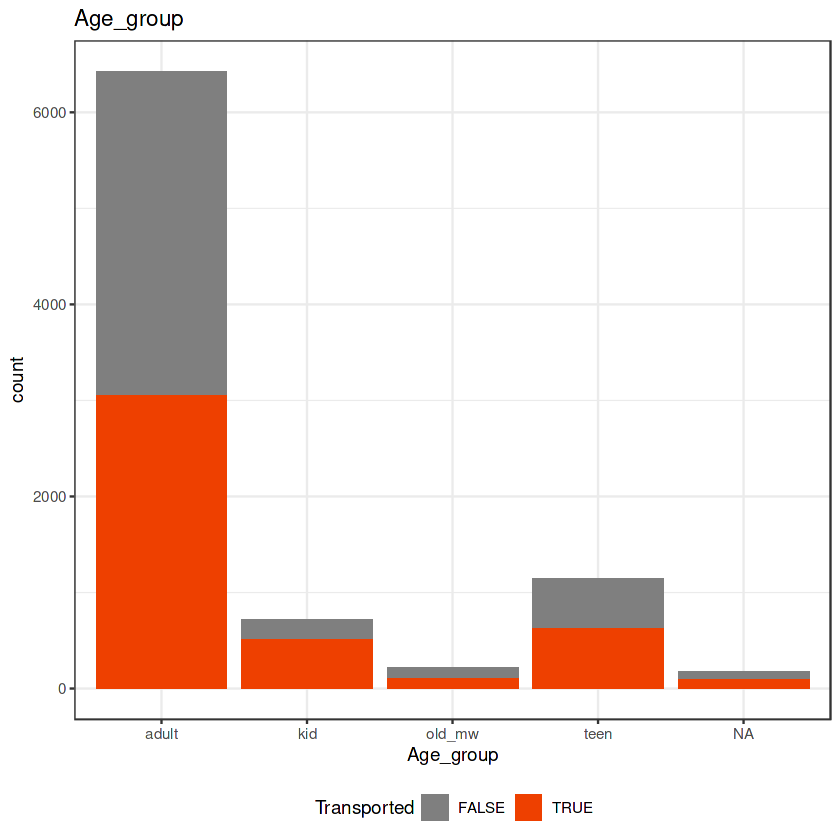

In [26]:
# Age by category
ggplot(data = train, aes(x = Age_group, y = after_stat(count), fill = Transported)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Age_group") +
  theme_bw() +
  theme(legend.position = "bottom")

> The number of NAs is similar to that of a category, for this reason, data will be imputed using random forest.

In [27]:
# Changing the type of variables
train$HomePlanet <- as.factor(train$HomePlanet)
train$CryoSleep <- as.logical(train$CryoSleep)
train$CabinDeck <- as.factor(train$CabinDeck)
train$CabinSide <- as.factor(train$CabinSide)
train$Destination <- as.factor(train$Destination)
train$VIP <- as.logical(train$VIP)
train$Age_group <- as.factor(train$Age_group)
train$Transported <- as.factor(train$Transported)

In [28]:
# Random Forest
mice_mod <- mice(data = train, method='rf')
train <- complete(mice_mod)


 iter imp variable
  1   1  Age_group
  1   2  Age_group
  1   3  Age_group
  1   4  Age_group
  1   5  Age_group
  2   1  Age_group
  2   2  Age_group
  2   3  Age_group
  2   4  Age_group
  2   5  Age_group
  3   1  Age_group
  3   2  Age_group
  3   3  Age_group
  3   4  Age_group
  3   5  Age_group
  4   1  Age_group
  4   2  Age_group
  4   3  Age_group
  4   4  Age_group
  4   5  Age_group
  5   1  Age_group
  5   2  Age_group
  5   3  Age_group
  5   4  Age_group
  5   5  Age_group


Warning message:
“Number of logged events: 26”


In [29]:
df_status(train)

       variable q_zeros p_zeros q_na p_na q_inf p_inf      type unique
1   PassengerId       0    0.00    0    0     0     0 character   8693
2    HomePlanet       0    0.00    0    0     0     0    factor      3
3     CryoSleep    5656   65.06    0    0     0     0   logical      2
4     CabinDeck       0    0.00    0    0     0     0    factor      9
5     CabinSide       0    0.00    0    0     0     0    factor      3
6   Destination       0    0.00    0    0     0     0    factor      3
7           VIP    8494   97.71    0    0     0     0   logical      2
8   RoomService    5758   66.24    0    0     0     0   numeric   1273
9     FoodCourt    5639   64.87    0    0     0     0   numeric   1507
10 ShoppingMall    5795   66.66    0    0     0     0   numeric   1115
11          Spa    5507   63.35    0    0     0     0   numeric   1327
12       VRDeck    5683   65.37    0    0     0     0   numeric   1306
13  Transported       0    0.00    0    0     0     0    factor      2
14    

> Complete imputation

In [30]:
# Placing target variable at the end
train <- train %>% relocate(Transported, .after = Age_group )

### Correlation analysis

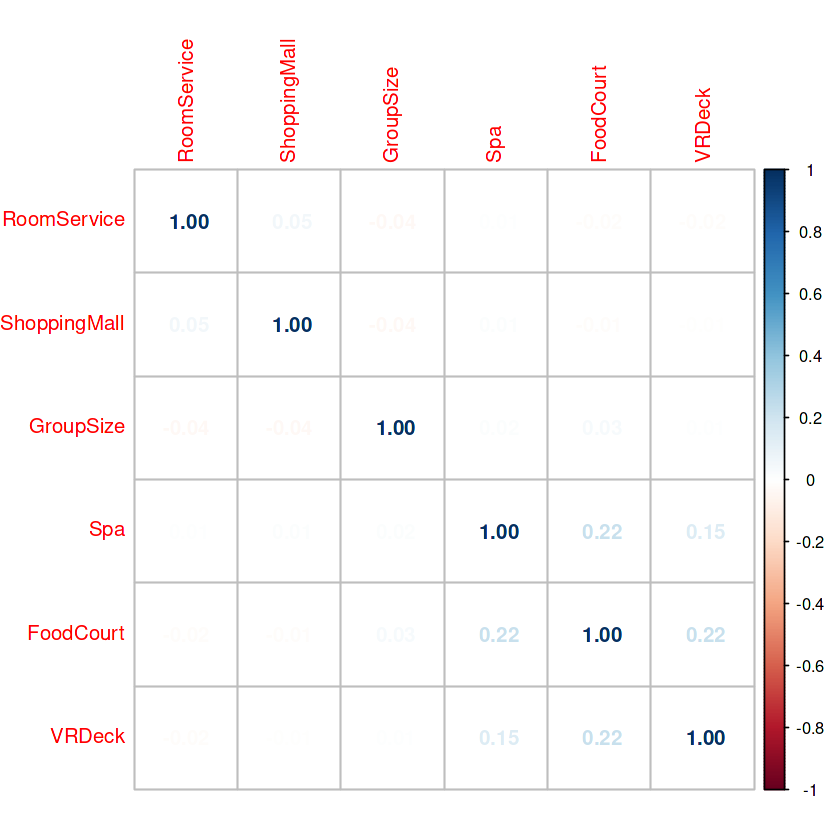

In [31]:
# Correlation map
train %>% 
  select_if(is.numeric) %>% 
  cor %>% 
  corrplot(method = 'number', order= 'hclust')

> There is **low correlation** between these attributes. Selection method isn´t used

### Outlier analysis

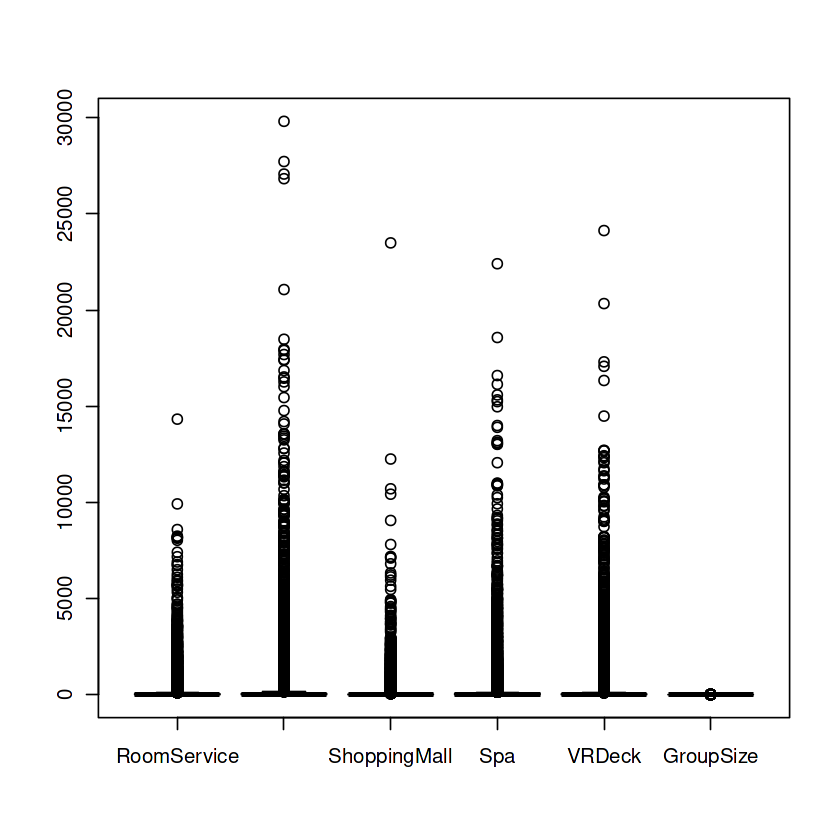

In [32]:
#Boxplots
boxplot(train %>%select_if(is.numeric))

> **There is a presence of outliers**. Therefore we limit the methods to use

# 4. Training

### Recipe

In [33]:
set.seed(123)
rct_bcoPor_bal <- train %>% recipe(Transported ~ . ) %>%
    step_other(all_nominal(), -all_outcomes() , threshold = 0.07, other = "other") %>%
    step_novel(all_nominal(), -all_outcomes() , new_level = "new") %>%
    step_corr(all_numeric(), -all_outcomes(), threshold = 0.9) %>%
    step_nzv(all_predictors()) %>%
    themis::step_upsample(Transported, over_ratio = 1, skip= TRUE, seed= 123) 

### Model

In [34]:
rf_sp <- rand_forest(
    mtry = tune(), trees = tune(), min_n = tune()) %>%
    set_engine("ranger", importance = "impurity") %>%
    set_mode("classification")

### Grid

In [35]:
set.seed(123)
rf_grid <- rf_sp %>%
    parameters() %>%
    update(min_n= min_n( range= c(30, 50)),
            mtry= mtry( range= c(4, 7))) %>%
    grid_latin_hypercube(size = 10)

Warning message:
“`parameters.model_spec()` was deprecated in tune 0.1.6.9003.
ℹ Please use `hardhat::extract_parameter_set_dials()` instead.”


### Workflow

In [36]:
rf_wflow <- workflow() %>%
    add_recipe(rct_bcoPor_bal) %>%
    add_model(rf_sp)

### Establishment of the object that integrates workflow, resampling, parameters and metrics

In [37]:
# Metrics
set.seed(1234)
cv_banco <- vfold_cv(train, v =5, repeats = 1, strata = Transported)
metricas <- metric_set(roc_auc, accuracy, sens, spec, bal_accuracy)
# Object
set.seed(123)
rf_tuned <- tune_grid(
      rf_wflow,
      resamples= cv_banco,
      grid = rf_grid,
      metrics = metricas,
      control= control_grid(allow_par = T, save_pred = T)
)

In [38]:
# for accuracy
show_best(rf_tuned, metric = 'accuracy', n = 10)

mtry,trees,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,1370,39,accuracy,binary,0.7976538,5,0.007103816,Preprocessor1_Model06
5,1904,41,accuracy,binary,0.7966186,5,0.007099378,Preprocessor1_Model09
5,70,45,accuracy,binary,0.7966178,5,0.006162322,Preprocessor1_Model01
5,1441,37,accuracy,binary,0.7955832,5,0.007523030,Preprocessor1_Model10
5,325,33,accuracy,binary,0.7955828,5,0.006737325,Preprocessor1_Model08
6,467,34,accuracy,binary,0.7944327,5,0.007730166,Preprocessor1_Model02
6,1124,48,accuracy,binary,0.7940874,5,0.007002325,Preprocessor1_Model04
6,1737,48,accuracy,binary,0.7937427,5,0.007106109,Preprocessor1_Model03
7,773,32,accuracy,binary,0.7928224,5,0.007810465,Preprocessor1_Model05


In [39]:
# for sens
show_best(rf_tuned, metric = 'sens', n = 10)

mtry,trees,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,773,32,sens,binary,0.7726535,5,0.011337986,Preprocessor1_Model05
6,1124,48,sens,binary,0.7712630,5,0.010132261,Preprocessor1_Model04
6,1737,48,sens,binary,0.7687138,5,0.011527073,Preprocessor1_Model03
6,467,34,sens,binary,0.7684820,5,0.009251140,Preprocessor1_Model02
6,950,42,sens,binary,0.7682503,5,0.010626426,Preprocessor1_Model07
5,70,45,sens,binary,0.7636153,5,0.007668780,Preprocessor1_Model01
5,325,33,sens,binary,0.7603708,5,0.008431040,Preprocessor1_Model08
5,1904,41,sens,binary,0.7594438,5,0.008652679,Preprocessor1_Model09
5,1441,37,sens,binary,0.7578216,5,0.009470599,Preprocessor1_Model10


In [40]:
# for bal accuracy
show_best(rf_tuned, metric = 'bal_accuracy', n = 10)

mtry,trees,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,1370,39,bal_accuracy,binary,0.7973452,5,0.007112095,Preprocessor1_Model06
5,70,45,bal_accuracy,binary,0.7963769,5,0.006137511,Preprocessor1_Model01
5,1904,41,bal_accuracy,binary,0.7963490,5,0.007100857,Preprocessor1_Model09
5,325,33,bal_accuracy,binary,0.7953270,5,0.006735831,Preprocessor1_Model08
5,1441,37,bal_accuracy,binary,0.7953089,5,0.007523482,Preprocessor1_Model10
6,467,34,bal_accuracy,binary,0.7942426,5,0.007712339,Preprocessor1_Model02
6,1124,48,bal_accuracy,binary,0.7939192,5,0.006994401,Preprocessor1_Model04
6,1737,48,bal_accuracy,binary,0.7935583,5,0.007110418,Preprocessor1_Model03
7,773,32,bal_accuracy,binary,0.7926741,5,0.007819895,Preprocessor1_Model05


> The results are very similar, bal accuracy is chosen by higher mean

In [41]:
# Using bal accuracy
rf_pars_fin <- select_best(rf_tuned, metric = 'bal_accuracy')
# Finishing the workflow
rf_wflow_fin <- rf_wflow %>% finalize_workflow(rf_pars_fin)
rf_fitted <- fit(rf_wflow_fin, train)

In [42]:
rf_model_fin <- extract_fit_parsnip(rf_fitted)
rf_model_fin

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, mtry = min_cols(~4L,      x), num.trees = ~1370L, min.node.size = min_rows(~39L, x),      importance = ~"impurity", num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  1370 
Sample size:                      8756 
Number of independent variables:  12 
Mtry:                             4 
Target node size:                 39 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.1242705 

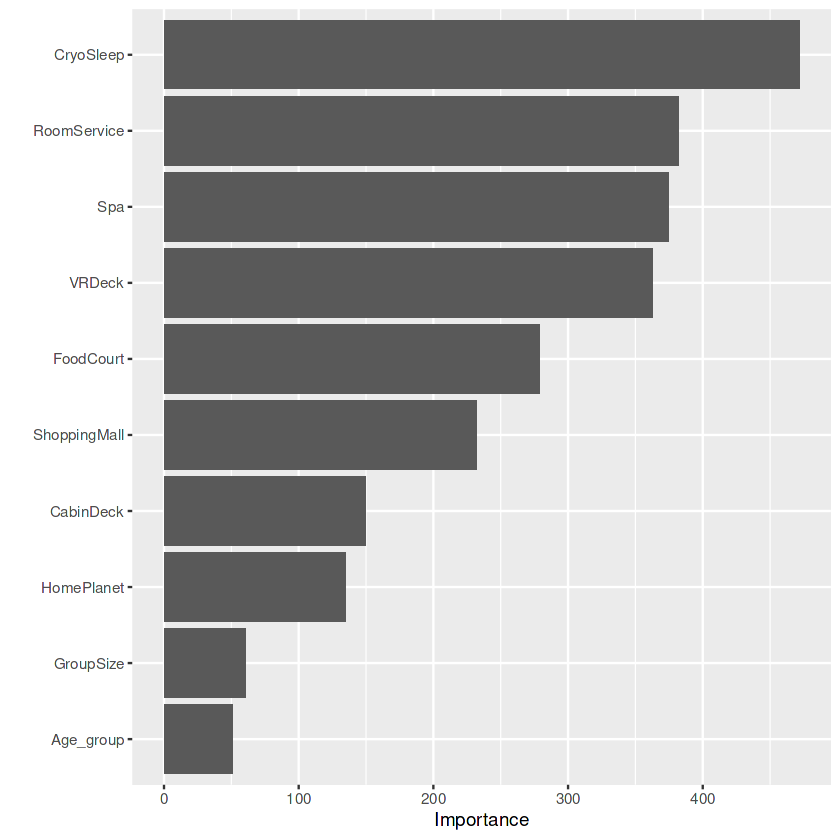

In [43]:
# Important attributes
vip(rf_model_fin)

> The most important attributes

In [44]:
# values of the metrics in train
train %>%
    predict(rf_fitted, new_data = . ) %>%
    mutate(Real= train$Transported) %>%
    conf_mat(truth = Real, estimate = .pred_class ) %>%
    summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8390659
kap,binary,0.6778877
sens,binary,0.7888760
spec,binary,0.8885336
ppv,binary,0.8746146
npv,binary,0.8102479
mcc,binary,0.6811258
j_index,binary,0.6774096
bal_accuracy,binary,0.8387048


>  **Accuracy**=**0.8389509**

# 5. TESTING

## Loading Dataset and Pre-processing of data

In [45]:
# Test data
test <- read_csv("/kaggle/input/spaceship-titanic/test.csv",show_col_types = FALSE)
head(test)

PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
<chr>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0013_01,Earth,TRUE,G/3/S,TRAPPIST-1e,27,FALSE,0,0,0,0,0,Nelly Carsoning
0018_01,Earth,FALSE,F/4/S,TRAPPIST-1e,19,FALSE,0,9,0,2823,0,Lerome Peckers
0019_01,Europa,TRUE,C/0/S,55 Cancri e,31,FALSE,0,0,0,0,0,Sabih Unhearfus
0021_01,Europa,FALSE,C/1/S,TRAPPIST-1e,38,FALSE,0,6652,0,181,585,Meratz Caltilter
0023_01,Earth,FALSE,F/5/S,TRAPPIST-1e,20,FALSE,10,0,635,0,0,Brence Harperez
0027_01,Earth,FALSE,F/7/P,TRAPPIST-1e,31,FALSE,0,1615,263,113,60,Karlen Ricks


In [46]:
# Information about the test
df_status(test)

       variable q_zeros p_zeros q_na p_na q_inf p_inf      type unique
1   PassengerId       0    0.00    0 0.00     0     0 character   4277
2    HomePlanet       0    0.00   87 2.03     0     0 character      3
3     CryoSleep    2640   61.73   93 2.17     0     0   logical      2
4         Cabin       0    0.00  100 2.34     0     0 character   3265
5   Destination       0    0.00   92 2.15     0     0 character      3
6           Age      82    1.92   91 2.13     0     0   numeric     79
7           VIP    4110   96.10   93 2.17     0     0   logical      2
8   RoomService    2726   63.74   82 1.92     0     0   numeric    842
9     FoodCourt    2690   62.89  106 2.48     0     0   numeric    902
10 ShoppingMall    2744   64.16   98 2.29     0     0   numeric    715
11          Spa    2611   61.05  101 2.36     0     0   numeric    833
12       VRDeck    2757   64.46   80 1.87     0     0   numeric    796
13         Name       0    0.00   94 2.20     0     0 character   4176


In [47]:
#Pre-proccesing
test <- test %>% separate(PassengerId, c("Group", "Num"), sep = "_", remove = FALSE) %>% 
    separate(Cabin, c("CabinDeck", "CabinNum", "CabinSide"), sep = "/") %>% 
    add_count(Group, name = "GroupSize") %>% 
    mutate(Age_group = case_when(Age <= 10  ~ "kid", Age > 10 & Age <= 18  ~ "teen", Age > 18 & Age <= 60  ~ "adult", Age > 60 ~ "old_mw")) %>% 
    select(-c(Group, Num, CabinNum, Age, Name))
test$HomePlanet <- test$HomePlanet %>% replace(is.na(.),"Earth")
test$CryoSleep <- test$CryoSleep %>% replace(is.na(.),"FALSE")
test$CabinDeck <- test$CabinDeck %>% replace(is.na(.),"N")
test$CabinSide <- test$CabinSide %>% replace(is.na(.),"N")
test$Destination <- test$Destination %>% replace(is.na(.),"TRAPPIST-1e")
test$VIP <- test$VIP %>% replace(is.na(.),"FALSE")
test <- mutate_at(test, c(8:12), ~replace(., is.na(.), 0)) %>%
        mutate(HomePlanet = as.factor(HomePlanet), CryoSleep = as.logical(CryoSleep), CabinDeck = as.factor(CabinDeck), CabinSide = as.factor(CabinSide),
           Destination = as.factor(Destination), VIP = as.logical(VIP), Age_group = as.factor(Age_group))
mice_mod <- mice(data = test, method='rf')
test <- complete(mice_mod)


 iter imp variable
  1   1  Age_group
  1   2  Age_group
  1   3  Age_group
  1   4  Age_group
  1   5  Age_group
  2   1  Age_group
  2   2  Age_group
  2   3  Age_group
  2   4  Age_group
  2   5  Age_group
  3   1  Age_group
  3   2  Age_group
  3   3  Age_group
  3   4  Age_group
  3   5  Age_group
  4   1  Age_group
  4   2  Age_group
  4   3  Age_group
  4   4  Age_group
  4   5  Age_group
  5   1  Age_group
  5   2  Age_group
  5   3  Age_group
  5   4  Age_group
  5   5  Age_group


Warning message:
“Number of logged events: 26”


## Prediction

In [48]:
# Prediction
Predict_transported <- predict(rf_fitted, test)
test <- cbind(test, Predict_transported) #unir dataframes
colnames(test)[15] <-"Predict_transported"
head(test)

,PassengerId,HomePlanet,CryoSleep,CabinDeck,CabinSide,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize,Age_group,Predict_transported
,<chr>,<fct>,<lgl>,<fct>,<fct>,<fct>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>
1,0013_01,Earth,TRUE,G,S,TRAPPIST-1e,FALSE,0,0,0,0,0,1,adult,TRUE
2,0018_01,Earth,FALSE,F,S,TRAPPIST-1e,FALSE,0,9,0,2823,0,1,adult,FALSE
3,0019_01,Europa,TRUE,C,S,55 Cancri e,FALSE,0,0,0,0,0,1,adult,TRUE
4,0021_01,Europa,FALSE,C,S,TRAPPIST-1e,FALSE,0,6652,0,181,585,1,adult,TRUE
5,0023_01,Earth,FALSE,F,S,TRAPPIST-1e,FALSE,10,0,635,0,0,1,adult,TRUE
6,0027_01,Earth,FALSE,F,P,TRAPPIST-1e,FALSE,0,1615,263,113,60,1,adult,TRUE


**CSV file**

In [49]:
submission <- data.frame(PassengerId = test$PassengerId, Transported = test$Predict_transported)
submission$Transported<- as.character(submission$Transported)
submission$Transported=str_to_title(submission$Transported)
write.csv(submission, file = "PredictTransported.csv", row.names = FALSE)